# freeze 0

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from transformers.models.roberta import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig
from transformers.optimization import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, precision_recall_fscore_support, roc_auc_score,auc, roc_curve, precision_recall_curve
from sklearn.preprocessing import label_binarize
from tqdm import tqdm
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from optuna.samplers import TPESampler
import warnings
warnings.filterwarnings('ignore')
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# =============================== CONFIGURATION =================================
class Config:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    max_len = 128
    batch_sizes = [8, 16, 32]
    max_epochs = 5
    # freeze_layers = [0, 2, 4, 6, 8, 10, 12]
    freeze_layers = [0]
    lr_min = 1e-6
    lr_max = 5e-5
    weight_decay_range = [0.001, 0.01, 0.1]
    dropout_range = [0.1, 0.2, 0.3, 0.4]
    gradient_clipping = 1.0
    warmup_ratio_range = [0.06, 0.1, 0.15]
    scheduler_types = ['linear', 'cosine']
    patience_range = [2, 3, 4]
    min_delta = 0.001
    output_model = "best_teacher_finetuned.pt"
    save_plots = True
    detailed_analysis = True
    n_trials = 10
    plot_dir = "training_plots"

# =============================== UTILITIES ====================================
class AdvancedEarlyStopping:
    def __init__(self, patience=3, min_delta=0.001, restore_best_weights=True, overfitting_patience=2, overfitting_threshold=0.05):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.overfitting_patience = overfitting_patience
        self.overfitting_threshold = overfitting_threshold
        self.counter = 0
        self.overfitting_counter = 0
        self.best_score = None
        self.best_weights = None
        self.early_stop = False

    def __call__(self, val_score, model, overfitting_severity='none'):
        performance_stop, overfitting_stop = False, False
        if self.best_score is None:
            self.best_score = val_score
            if self.restore_best_weights:
                self.best_weights = model.state_dict().copy()
        elif val_score < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                performance_stop = True
        else:
            self.best_score = val_score
            self.counter = 0
            if self.restore_best_weights:
                self.best_weights = model.state_dict().copy()
        if overfitting_severity in ['moderate', 'high']:
            self.overfitting_counter += 1
            if self.overfitting_counter >= self.overfitting_patience:
                overfitting_stop = True
        else:
            self.overfitting_counter = 0
        if performance_stop or overfitting_stop:
            self.early_stop = True
            if self.restore_best_weights and self.best_weights:
                model.load_state_dict(self.best_weights)
        return self.early_stop, performance_stop, overfitting_stop

class EnhancedModelAnalyzer:
    @staticmethod
    def detect_overfitting_advanced(train_metrics, val_metrics, history=None, threshold=0.05):
        acc_gap = train_metrics['acc'] - val_metrics['acc']
        loss_gap = val_metrics['loss'] - train_metrics['loss']
        f1_gap = train_metrics['f1'] - val_metrics['f1']
        trend_overfitting = False
        if history and len(history) >= 3:
            recent_val_accs = [h['val_acc'] for h in history[-3:]]
            recent_train_accs = [h['train_acc'] for h in history[-3:]]
            val_trend = np.polyfit(range(len(recent_val_accs)), recent_val_accs, 1)[0]
            train_trend = np.polyfit(range(len(recent_train_accs)), recent_train_accs, 1)[0]
            if train_trend > 0.001 and val_trend < -0.001:
                trend_overfitting = True
        if acc_gap > 0.15 or loss_gap > 0.3 or trend_overfitting:
            severity = 'high'
        elif acc_gap > 0.1 or loss_gap > 0.2:
            severity = 'moderate'
        elif acc_gap > threshold or loss_gap > 0.1:
            severity = 'low'
        else:
            severity = 'none'
        return {
            'accuracy_gap': acc_gap,
            'loss_gap': loss_gap,
            'f1_gap': f1_gap,
            'trend_overfitting': trend_overfitting,
            'is_overfitting': acc_gap > threshold or loss_gap > 0.1 or trend_overfitting,
            'severity': severity,
            'recommendation': EnhancedModelAnalyzer._get_enhanced_recommendation(severity, acc_gap, loss_gap, trend_overfitting)
        }

    @staticmethod
    def _get_enhanced_recommendation(severity, acc_gap, loss_gap, trend_overfitting):
        if severity == 'high':
            recs = ["Strong overfitting detected!"]
            if trend_overfitting:
                recs.append("Validation performance declining while training improves.")
            recs.extend(["Immediate actions: Stop training, increase regularization",
                         "Next trial: Higher weight decay, more dropout, fewer epochs"])
            return " ".join(recs)
        elif severity == 'moderate':
            return f"Moderate overfitting (acc_gap: {acc_gap:.3f}). Consider: early stopping, increase dropout to 0.3-0.4"
        elif severity == 'low':
            return f"Minor overfitting (acc_gap: {acc_gap:.3f}). Monitor closely, consider slight regularization increase"
        else:
            return "Good generalization. Model performing well."

# ============================== PLOTTING ======================================
class AdvancedPlotter:
    def __init__(self, save_dir="training_plots"):
        self.save_dir = save_dir
        os.makedirs(save_dir, exist_ok=True)
    def plot_confusion_matrix(self, y_true, y_pred, class_names=None, filename="confusion_matrix.png"):
        plt.figure(figsize=(8,6))
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                    xticklabels=class_names, yticklabels=class_names)
        plt.xlabel("Predicted label")
        plt.ylabel("True label")
        plt.title("Confusion Matrix")
        plt.tight_layout()
        plt.savefig(os.path.join(self.save_dir, filename))
        plt.close()

    def plot_normalized_confusion_matrix(self, y_true, y_pred, class_names=None, filename="confusion_matrix_normalized.png"):
        plt.figure(figsize=(8,6))
        cm = confusion_matrix(y_true, y_pred, normalize='true')
        sns.heatmap(cm, annot=True, fmt=".2f", cmap="Reds", cbar=False,
                    xticklabels=class_names, yticklabels=class_names)
        plt.xlabel("Predicted label")
        plt.ylabel("True label")
        plt.title("Normalized Confusion Matrix")
        plt.tight_layout()
        plt.savefig(os.path.join(self.save_dir, filename))
        plt.close()

    def plot_roc_curve(self, y_true, y_prob, filename="roc_curve.png"):
        # Determine number of classes from prediction probabilities shape
        n_classes = y_prob.shape[1]
        # Binarize true labels for multi-class ROC computation
        y_true_bin = label_binarize(y_true, classes=range(n_classes))

        plt.figure(figsize=(8, 6))
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.3f})")

        plt.plot([0, 1], [0, 1], "k--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Multi-class ROC Curve")
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.savefig(os.path.join(self.save_dir, filename))
        plt.close()
        
    def plot_pr_curve(self, y_true, y_prob, filename="precision_recall_curve.png"):
        n_classes = y_prob.shape[1]
        y_true_bin = label_binarize(y_true, classes=range(n_classes))
        plt.figure(figsize=(8,6))
        for i in range(n_classes):
            precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_prob[:, i])
        plt.plot(recall, precision, lw=2, label=f'class {i}')
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("Precision-Recall Curve (One-vs-Rest)")
        plt.legend(loc="best")
        plt.tight_layout()
        plt.savefig(os.path.join(self.save_dir, filename))
        plt.close()

    def create_comprehensive_evaluation_report(self, y_true, y_pred, y_prob, trial_params, history, trial_id=None, save=True):
        report = classification_report(y_true, y_pred, output_dict=True)
        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='weighted')
        auc = roc_auc_score(y_true, y_prob, multi_class='ovr')
        metrics = {
            "accuracy": acc,
            "f1_weighted": f1,
            "roc_auc": auc,
            "classification_report": report,
            "trial_params": trial_params,
            "history": history
        }
        if save:
            base_filename = f"trial_{trial_id}" if trial_id is not None else "final"
            # Save JSON metrics
            with open(os.path.join(self.save_dir, f"{base_filename}_metrics.json"), "w") as f:
                json.dump(metrics, f, indent=2)
            # Save plots
            class_names = ['Class 0', 'Class 1']
            self.plot_confusion_matrix(y_true, y_pred, class_names, filename=f"{base_filename}_confusion.png")
            self.plot_normalized_confusion_matrix(y_true, y_pred, class_names, filename=f"{base_filename}_confusion_normalized.png")
            self.plot_roc_curve(y_true, y_prob, filename=f"{base_filename}_roc.png")
            self.plot_pr_curve(y_true, y_prob, filename=f"{base_filename}_pr.png")
        return metrics

# =============== DATASET AND TRAINING MODULES (summarized) ====================
print("Loading PubMed RCT dataset...")
dataset = load_dataset(
        "csv",
        data_files={
            "train": "./data/train.txt",
            "validation": "./data/dev.txt",
            "test": "./data/test.txt"
        },
        delimiter="\t",
        column_names=["label", "text"]
    )
# Filter only valid labels
valid_labels = {"BACKGROUND", "OBJECTIVE", "METHODS", "RESULTS", "CONCLUSIONS"}
dataset = dataset.filter(lambda x: x["label"] in valid_labels)

# Map string labels to integer indices
label_map = {"BACKGROUND": 0, "OBJECTIVE": 1, "METHODS": 2, "RESULTS": 3, "CONCLUSIONS": 4}
def encode_label(example):
    example["label"] = label_map[example["label"]]
    return example

dataset = dataset.map(encode_label)
# Print diagnostics
for split in ["train", "validation", "test"]:
    labels = set(dataset[split]["label"])
    print(f"{split} labels: {labels}, size: {len(dataset[split])}")
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

def preprocess(examples):
    # Tokenization of the text column
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=Config.max_len)

tokenized_train = dataset["train"].map(preprocess, batched=True)
tokenized_validation = dataset["validation"].map(preprocess, batched=True)
tokenized_test = dataset["test"].map(preprocess, batched=True)

tokenized_train.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
tokenized_validation.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
tokenized_test.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

train_loader = DataLoader(tokenized_train, batch_size=8)
for batch in train_loader:
    print({k: v.shape for k, v in batch.items()})
    break

# train_loader = DataLoader(tokenized_train, batch_size=params["batch_size"], shuffle=True)
# val_loader = DataLoader(tokenized_validation, batch_size=params["batch_size"])
# test_loader = DataLoader(tokenized_test, batch_size=params["batch_size"])



# def preprocess(example):
#     encoding = tokenizer(
#         example["text"],
#         max_length=Config.max_len,
#         truncation=True,
#         padding="max_length",
#         return_tensors="pt"
#     )
#     return {
#         "input_ids": encoding["input_ids"].squeeze(),
#         "attention_mask": encoding["attention_mask"].squeeze(),
#         "label": example["label"]
#     }

# train_dataset = dataset["train"].map(preprocess)
# val_dataset = dataset["test"].map(preprocess)
# train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
# val_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
train_eval_indices = np.random.choice(len(tokenized_train), size=min(5000, len(tokenized_train)), replace=False)
train_eval_dataset = tokenized_train.select(train_eval_indices)

def freeze_transformer_layers(model, freeze_n, freeze_embed=False, freeze_classifier=False):
    backbone = model.roberta
    for param in backbone.embeddings.parameters():
        param.requires_grad = not freeze_embed
    for i, layer in enumerate(backbone.encoder.layer):
        for param in layer.parameters():
            param.requires_grad = (i >= freeze_n)
    for param in model.classifier.parameters():
        param.requires_grad = not freeze_classifier

def comprehensive_evaluate(model, dataloader, device, return_predictions=False):
    model.eval()
    all_preds, all_labels, all_probs = [], [], []
    total_loss = 0
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
            total_loss += loss.item()
            probs = torch.softmax(logits, dim=-1)
            preds = torch.argmax(logits, dim=-1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision, recall, f1_macro, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')
    metrics = {'loss': total_loss / len(dataloader), 'acc': acc, 'f1': f1, 'f1_macro': f1_macro, 'precision': precision, 'recall': recall}
    if return_predictions:
        return metrics, all_preds, all_labels, np.array(all_probs)
    else:
        return metrics

def train_with_advanced_monitoring(model, train_loader, train_eval_loader, val_loader, optimizer, scheduler, max_epochs, freeze_n, trial_params, trial_id=None, plotter=None):
    history = []
    early_stopping = AdvancedEarlyStopping(patience=trial_params['patience'], min_delta=Config.min_delta, overfitting_patience=2, overfitting_threshold=0.05)
    analyzer = EnhancedModelAnalyzer()
    for epoch in range(max_epochs):
        model.train()
        epoch_train_loss = 0; num_batches = 0
        for batch in tqdm(train_loader, desc=f"[Freeze {freeze_n}] Epoch {epoch+1}/{max_epochs}", leave=False):
            input_ids = batch["input_ids"].to(Config.device)
            attention_mask = batch["attention_mask"].to(Config.device)
            labels = batch["label"].to(Config.device)
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            if Config.gradient_clipping > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), Config.gradient_clipping)
            optimizer.step()
            if scheduler:
                scheduler.step()
            epoch_train_loss += loss.item()
            num_batches += 1
        avg_train_loss = epoch_train_loss / num_batches
        train_metrics = comprehensive_evaluate(model, train_eval_loader, Config.device)
        val_metrics, val_preds, val_labels, val_probs = comprehensive_evaluate(model, val_loader, Config.device, return_predictions=True)
        overfitting_analysis = analyzer.detect_overfitting_advanced(train_metrics, val_metrics, history, threshold=0.05)
        epoch_info = {'epoch': epoch + 1, 'train_loss': avg_train_loss, 'train_acc': train_metrics['acc'], 'train_f1': train_metrics['f1'],
                      'val_loss': val_metrics['loss'], 'val_acc': val_metrics['acc'], 'val_f1': val_metrics['f1'], 'overfitting_analysis': overfitting_analysis}
        history.append(epoch_info)
        early_stop, perf_stop, overfit_stop = early_stopping(val_metrics['acc'], model, overfitting_analysis['severity'])
        print(f"Epoch {epoch + 1}/{max_epochs} completed. Avg train loss: {epoch_train_loss / num_batches:.4f}")
        if early_stop:
            break
    evaluation_summary = None
    if plotter:
        evaluation_summary = plotter.create_comprehensive_evaluation_report(val_labels, val_preds, val_probs, trial_params, history, trial_id, save=Config.save_plots)
    return history, val_preds, val_labels, val_probs, evaluation_summary

def create_optimized_trial(trial):
    params = {
        'freeze_n': trial.suggest_categorical('freeze_n', Config.freeze_layers),
        'batch_size': trial.suggest_categorical('batch_size', Config.batch_sizes),
        'lr': trial.suggest_float('lr', Config.lr_min, Config.lr_max, log=True),
        'weight_decay': trial.suggest_categorical('weight_decay', Config.weight_decay_range),
        'dropout_rate': trial.suggest_categorical('dropout_rate', Config.dropout_range),
        'warmup_ratio': trial.suggest_categorical('warmup_ratio', Config.warmup_ratio_range),
        'scheduler_type': trial.suggest_categorical('scheduler_type', Config.scheduler_types),
        'patience': trial.suggest_categorical('patience', Config.patience_range),
        'max_epochs': trial.suggest_int('max_epochs', 2, Config.max_epochs)
    }
    plotter = AdvancedPlotter(save_dir=f"{Config.plot_dir}/trial_{trial.number}")
    train_loader = DataLoader(tokenized_train, batch_size=params['batch_size'], shuffle=True)
    val_loader = DataLoader(tokenized_validation, batch_size=params['batch_size'])
    train_eval_loader = DataLoader(train_eval_dataset, batch_size=params['batch_size'])
    config = RobertaConfig.from_pretrained("roberta-base")
    config.hidden_dropout_prob = params['dropout_rate']
    config.attention_probs_dropout_prob = params['dropout_rate']
    config.num_labels = 5
    model = RobertaForSequenceClassification.from_pretrained("roberta-base", config=config).to(Config.device)
    freeze_transformer_layers(model, params['freeze_n'])
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=params['lr'], weight_decay=params['weight_decay'])
    total_steps = len(train_loader) * params['max_epochs']
    warmup_steps = int(params['warmup_ratio'] * total_steps)
    if params['scheduler_type'] == 'linear':
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)
    else:
        scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)
    history, val_preds, val_labels, val_probs, evaluation_summary = train_with_advanced_monitoring(
        model, train_loader, train_eval_loader, val_loader, optimizer, scheduler, params['max_epochs'], params['freeze_n'],
        params, trial_id=trial.number, plotter=plotter
    )
    final_val_acc = history[-1]['val_acc']
    final_overfitting_severity = history[-1]['overfitting_analysis']['severity']
    overfitting_penalty = {'none': 0.0, 'low': 0.01, 'moderate': 0.03, 'high': 0.05}.get(final_overfitting_severity, 0.0)
    final_score = final_val_acc - overfitting_penalty
    trial.report(final_score, len(history))
    trial.set_user_attr('final_val_acc', final_val_acc)
    trial.set_user_attr('overfitting_severity', final_overfitting_severity)
    trial.set_user_attr('epochs_trained', len(history))
    trial.set_user_attr('early_stopped', len(history) < params['max_epochs'])
    trial.set_user_attr('evaluation_summary', evaluation_summary)
    return final_score

def run_advanced_hyperparameter_optimization():
    os.makedirs(Config.plot_dir, exist_ok=True)
    study = optuna.create_study(
        direction='maximize',
        sampler=TPESampler(seed=42),
        pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=1)
    )
    study.optimize(create_optimized_trial, n_trials=Config.n_trials, show_progress_bar=True)
    main_plotter = AdvancedPlotter(save_dir=Config.plot_dir)
    main_plotter.plot_hyperparameter_importance(study, save=Config.save_plots)
    best_params = study.best_params
    final_plotter = AdvancedPlotter(save_dir=f"{Config.plot_dir}/final_model")
    train_loader = DataLoader(tokenized_train, batch_size=best_params['batch_size'], shuffle=True)
    val_loader = DataLoader(tokenized_validation, batch_size=best_params['batch_size'])
    train_eval_loader = DataLoader(train_eval_dataset, batch_size=best_params['batch_size'])
    config = RobertaConfig.from_pretrained("roberta-base")
    config.hidden_dropout_prob = best_params['dropout_rate']
    config.attention_probs_dropout_prob = best_params['dropout_rate']
    config.num_labels = 5
    final_model = RobertaForSequenceClassification.from_pretrained("roberta-base", config=config).to(Config.device)
    freeze_transformer_layers(final_model, best_params['freeze_n'])
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, final_model.parameters()), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
    total_steps = len(train_loader) * best_params['max_epochs']
    warmup_steps = int(best_params['warmup_ratio'] * total_steps)
    if best_params['scheduler_type'] == 'linear':
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)
    else:
        scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)
    final_history, final_val_preds, final_val_labels, final_val_probs, final_evaluation = train_with_advanced_monitoring(
        final_model, train_loader, train_eval_loader, val_loader, optimizer, scheduler, best_params['max_epochs'],
        best_params['freeze_n'], best_params, trial_id="FINAL", plotter=final_plotter)
    torch.save(final_model.state_dict(), Config.output_model)
    print(f"💾 Final optimized model saved to: {Config.output_model}")
    print(f"\n📁 All plots and reports saved to: {Config.plot_dir}/")
    return study, final_history, best_params, final_evaluation

if __name__ == "__main__":
    study, final_history, best_params, final_evaluation = run_advanced_hyperparameter_optimization()
    print("🎉 Advanced Hyperparameter Optimization with Comprehensive Analysis Complete!")


Loading PubMed RCT dataset...


KeyboardInterrupt: 

In [1]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("in fine tuning Device: ", device)

in fine tuning Device:  cuda


In [ ]:
{'freeze_n': 0, 'batch_size': 16, 'lr': 1.0401663679887314e-05, 'weight_decay': 0.001, 'dropout_rate': 0.1, 'warmup_ratio': 0.06, 'scheduler_type': 'cosine', 'patience': 3, 'max_epochs': 3}

# final model

Loading PubMed RCT dataset...


Map: 100%|██████████| 30135/30135 [00:06<00:00, 4376.66 examples/s]
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1 Training: 100%|██████████| 11253/11253 [29:43<00:00,  6.31it/s]


Epoch 1: Train Loss=0.4592, Train Acc=0.8296, Val Loss=0.3474, Val Acc=0.8722, Val F1=0.8691
Model saved at epoch 1


Epoch 2 Training: 100%|██████████| 11253/11253 [29:40<00:00,  6.32it/s]


Epoch 2: Train Loss=0.3408, Train Acc=0.8763, Val Loss=0.3429, Val Acc=0.8757, Val F1=0.8759
Model saved at epoch 2


Epoch 3 Training: 100%|██████████| 11253/11253 [29:42<00:00,  6.31it/s]


Epoch 3: Train Loss=0.2936, Train Acc=0.8921, Val Loss=0.3377, Val Acc=0.8780, Val F1=0.8780
Model saved at epoch 3


Epoch 4 Training: 100%|██████████| 11253/11253 [29:39<00:00,  6.32it/s]


Epoch 4: Train Loss=0.2516, Train Acc=0.9072, Val Loss=0.3440, Val Acc=0.8809, Val F1=0.8798


Epoch 5 Training: 100%|██████████| 11253/11253 [29:41<00:00,  6.32it/s]


Epoch 5: Train Loss=0.2260, Train Acc=0.9170, Val Loss=0.3542, Val Acc=0.8801, Val F1=0.8793
📈 Training curves saved to validation_plots_t1_kfold/training_curves.png


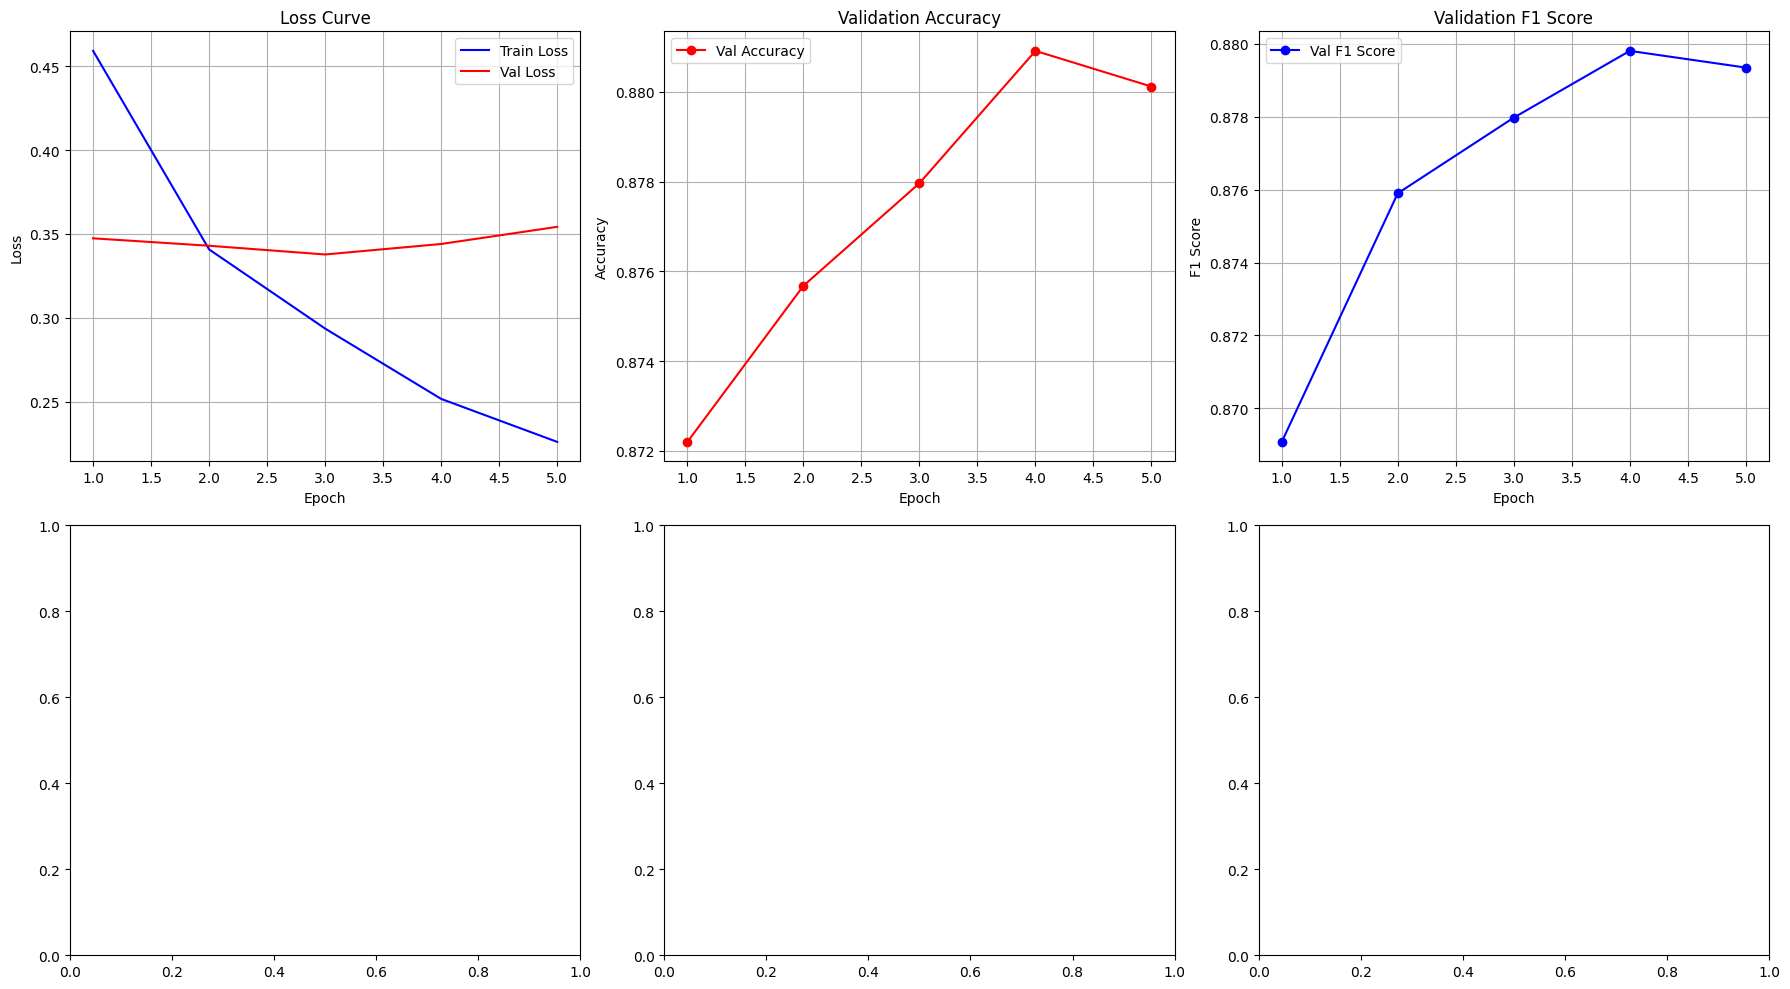

📊 Confusion matrix saved: validation_plots_t1_kfold/confusion_matrix_fold_0.png


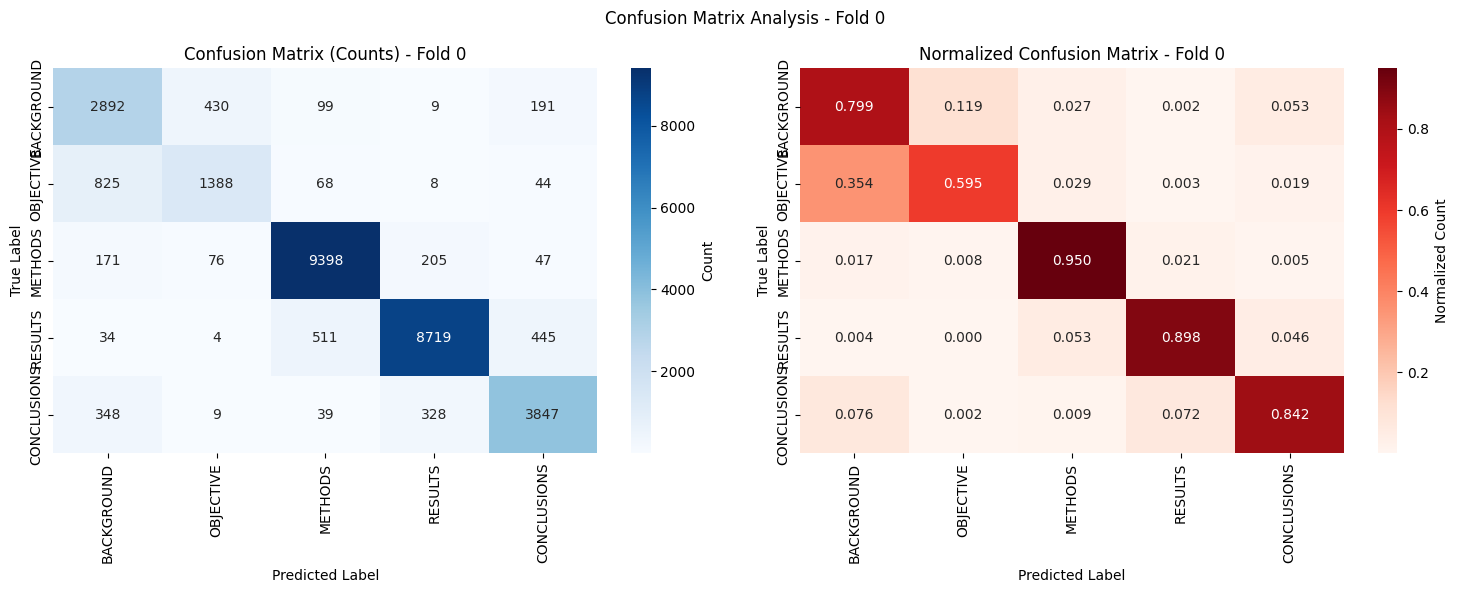

📈 ROC/PR curves saved: validation_plots_t1_kfold/roc_pr_fold_0.png


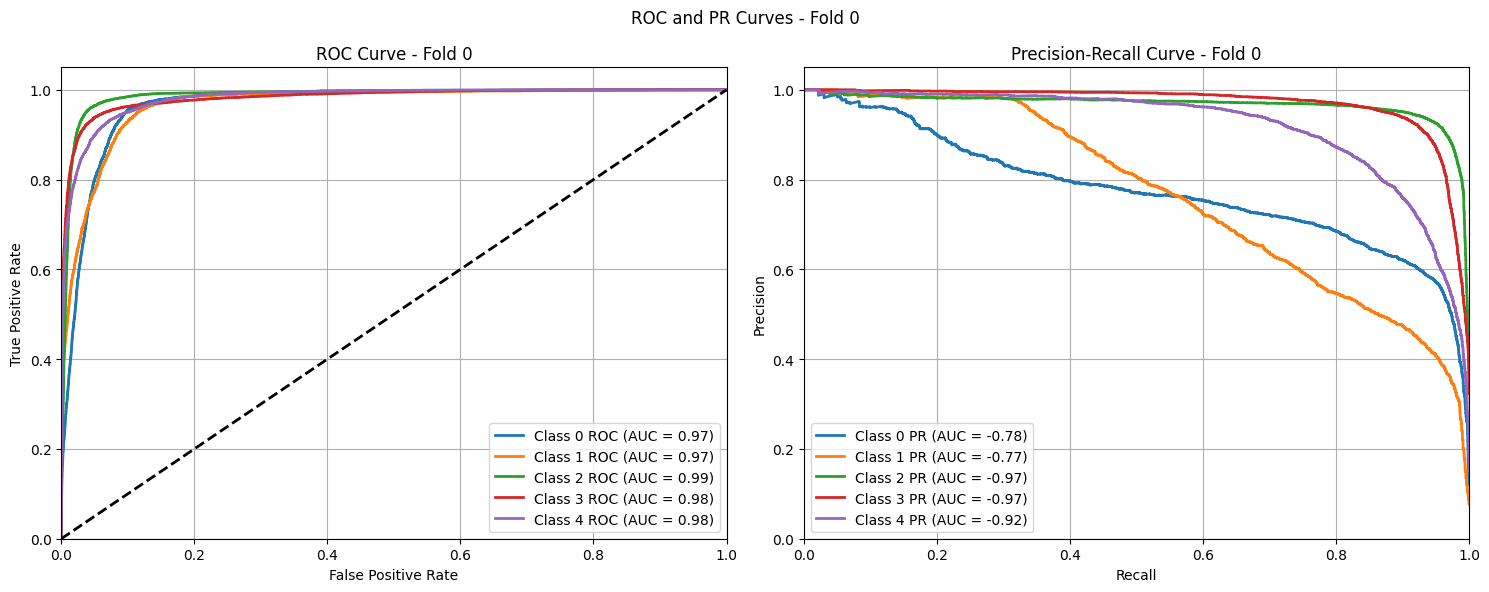


CLASSIFICATION REPORT TABLE - Fold 0
Class           Precision  Recall     F1-Score   Support   
------------------------------------------------------------
BACKGROUND      0.6773     0.7987     0.7330     3621      
OBJECTIVE       0.7278     0.5949     0.6547     2333      
METHODS         0.9291     0.9496     0.9392     9897      
RESULTS         0.9407     0.8977     0.9187     9713      
CONCLUSIONS     0.8411     0.8416     0.8413     4571      
------------------------------------------------------------
Macro Avg       0.8232     0.8165     0.8174     30135     
Weighted Avg    0.8736     0.8709     0.8709     30135     
------------------------------------------------------------

💾 Classification report saved: validation_plots_t1_kfold/classification_report_fold_0.json

COMPREHENSIVE EVALUATION METRICS - Fold 0
Accuracy: 0.8709
F1 Score (Weighted): 0.8709
F1 Score (Macro): 0.8174
ROC AUC (Macro-average): 0.9769
Confusion Matrix:
[[2892  430   99    9  191]
 [ 825 1388   68

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig
from transformers.optimization import get_cosine_schedule_with_warmup, get_linear_schedule_with_warmup
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, classification_report
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
warnings.filterwarnings('ignore')

# Configuration class
class Config:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    max_len = 128
    freeze_n = 0
    batch_size = 16
    lr = 1.0401663679887314e-05
    weight_decay = 0.001
    dropout_rate = 0.1
    warmup_ratio = 0.06
    scheduler_type = 'cosine'
    patience = 3
    max_epochs = 5
    save_plots = True
    plot_dir = "validation_plots_t1_kfold"
    output_model = "t1.pt"

# ComprehensiveEvaluator class containing all plotting and metric report functions
class ComprehensiveEvaluator:
    def __init__(self, save_dir="evaluation_results"):
        self.save_dir = save_dir
        os.makedirs(save_dir, exist_ok=True)
    
    def plot_comprehensive_training_curves(self, history, save=True):
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        epochs = range(1, len(history) + 1)

        val_loss = [h['val_loss'] for h in history]
        train_loss = [h['train_loss'] for h in history]
        val_acc = [h['val_acc'] for h in history]
        val_f1 = [h['val_f1'] for h in history]

        axes[0, 0].plot(epochs, train_loss, 'b-', label='Train Loss')
        axes[0, 0].plot(epochs, val_loss, 'r-', label='Val Loss')
        axes[0, 0].set_title('Loss Curve')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True)

        axes[0, 1].plot(epochs, val_acc, 'r-o', label='Val Accuracy')
        axes[0, 1].set_title('Validation Accuracy')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Accuracy')
        axes[0, 1].legend()
        axes[0, 1].grid(True)

        axes[0, 2].plot(epochs, val_f1, 'b-o', label='Val F1 Score')
        axes[0, 2].set_title('Validation F1 Score')
        axes[0, 2].set_xlabel('Epoch')
        axes[0, 2].set_ylabel('F1 Score')
        axes[0, 2].legend()
        axes[0, 2].grid(True)

        if save:
            filename = f"{self.save_dir}/training_curves.png"
            plt.savefig(filename, dpi=300, bbox_inches='tight')
            print(f"📈 Training curves saved to {filename}")

        plt.tight_layout()
        plt.show()
        return fig

    def plot_confusion_matrix_advanced(self, y_true, y_pred, fold, save=True):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        cm = confusion_matrix(y_true, y_pred)
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
                   xticklabels=['BACKGROUND', 'OBJECTIVE', 'METHODS', 'RESULTS', 'CONCLUSIONS'], 
                   yticklabels=['BACKGROUND', 'OBJECTIVE', 'METHODS', 'RESULTS', 'CONCLUSIONS'],
                   cbar_kws={'label': 'Count'})
        ax1.set_title(f'Confusion Matrix (Counts) - Fold {fold}')
        ax1.set_xlabel('Predicted Label')
        ax1.set_ylabel('True Label')
        
        cm_normalized = confusion_matrix(y_true, y_pred, normalize='true')
        sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Reds', ax=ax2,
                   xticklabels=['BACKGROUND', 'OBJECTIVE', 'METHODS', 'RESULTS', 'CONCLUSIONS'], 
                   yticklabels=['BACKGROUND', 'OBJECTIVE', 'METHODS', 'RESULTS', 'CONCLUSIONS'],
                   cbar_kws={'label': 'Normalized Count'})
        ax2.set_title(f'Normalized Confusion Matrix - Fold {fold}')
        ax2.set_xlabel('Predicted Label')
        ax2.set_ylabel('True Label')
        
        fig.suptitle(f'Confusion Matrix Analysis - Fold {fold}')
        plt.tight_layout()
        
        if save:
            filename = f"{self.save_dir}/confusion_matrix_fold_{fold}.png"
            plt.savefig(filename, dpi=300, bbox_inches='tight')
            print(f"📊 Confusion matrix saved: {filename}")
        
        plt.show()
        return fig, cm

    def plot_roc_and_pr_curves(self, y_true, y_probs, fold, save=True):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        n_classes = y_probs.shape[1]
        # Binarize the output for multiclass ROC and PR calculation
        from sklearn.preprocessing import label_binarize
        y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

        # Plot ROC for each class
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
            roc_auc = roc_auc_score(y_true_bin[:, i], y_probs[:, i])
            ax1.plot(fpr, tpr, lw=2, label=f'Class {i} ROC (AUC = {roc_auc:.2f})')

        ax1.plot([0, 1], [0, 1], 'k--', lw=2)
        ax1.set_xlim([0.0, 1.0])
        ax1.set_ylim([0.0, 1.05])
        ax1.set_title(f'ROC Curve - Fold {fold}')
        ax1.set_xlabel('False Positive Rate')
        ax1.set_ylabel('True Positive Rate')
        ax1.legend(loc='lower right')
        ax1.grid(True)

        # Plot Precision-Recall for each class
        for i in range(n_classes):
            precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_probs[:, i])
            pr_auc = np.trapz(precision, recall)
            ax2.plot(recall, precision, lw=2, label=f'Class {i} PR (AUC = {pr_auc:.2f})')

        ax2.set_xlim([0.0, 1.0])
        ax2.set_ylim([0.0, 1.05])
        ax2.set_title(f'Precision-Recall Curve - Fold {fold}')
        ax2.set_xlabel('Recall')
        ax2.set_ylabel('Precision')
        ax2.legend(loc='lower left')
        ax2.grid(True)

        fig.suptitle(f'ROC and PR Curves - Fold {fold}')
        plt.tight_layout()

        if save:
            filename = f"{self.save_dir}/roc_pr_fold_{fold}.png"
            plt.savefig(filename, dpi=300, bbox_inches='tight')
            print(f"📈 ROC/PR curves saved: {filename}")

        plt.show()
        return fig

    def create_classification_table(self, y_true, y_pred, fold, save=True):
        class_report = classification_report(y_true, y_pred, target_names=['BACKGROUND', 'OBJECTIVE', 'METHODS', 'RESULTS', 'CONCLUSIONS'], output_dict=True)
        print(f"\n{'='*80}")
        print(f"CLASSIFICATION REPORT TABLE - Fold {fold}")
        print("="*80)
        print(f"{'Class':<15} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<10}")
        print("-" * 60)
        for class_name in ['BACKGROUND', 'OBJECTIVE', 'METHODS', 'RESULTS', 'CONCLUSIONS']:
            precision = class_report[class_name]['precision']
            recall = class_report[class_name]['recall']
            f1 = class_report[class_name]['f1-score']
            support = int(class_report[class_name]['support'])
            print(f"{class_name:<15} {precision:<10.4f} {recall:<10.4f} {f1:<10.4f} {support:<10}")
        print("-" * 60)
        macro_avg = class_report['macro avg']
        print(f"{'Macro Avg':<15} {macro_avg['precision']:<10.4f} {macro_avg['recall']:<10.4f} {macro_avg['f1-score']:<10.4f} {int(macro_avg['support']):<10}")
        weighted_avg = class_report['weighted avg']
        print(f"{'Weighted Avg':<15} {weighted_avg['precision']:<10.4f} {weighted_avg['recall']:<10.4f} {weighted_avg['f1-score']:<10.4f} {int(weighted_avg['support']):<10}")
        print("-" * 60)

        if save:
            filename = f"{self.save_dir}/classification_report_fold_{fold}.json"
            with open(filename, 'w') as f:
                json.dump(class_report, f, indent=2)
            print(f"\n💾 Classification report saved: {filename}")
        
        return class_report

    def create_comprehensive_evaluation_metrics(self, y_true, y_pred, y_probs, fold, save=True):
        print(f"\n{'='*80}")
        print(f"COMPREHENSIVE EVALUATION METRICS - Fold {fold}")
        print("="*80)
        
        acc = accuracy_score(y_true, y_pred)
        f1_weighted = f1_score(y_true, y_pred, average='weighted')
        f1_macro = f1_score(y_true, y_pred, average='macro')
        precision_macro, recall_macro, _, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
        
        n_classes = y_probs.shape[1]
        from sklearn.preprocessing import label_binarize
        y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))
        
        roc_auc = 0.0
        for i in range(n_classes):
            try:
                roc_auc += roc_auc_score(y_true_bin[:, i], y_probs[:, i])
            except:
                pass
        roc_auc /= n_classes

        # Confusion matrix is generalized with multilabel
        cm = confusion_matrix(y_true, y_pred)
        
        print(f"Accuracy: {acc:.4f}")
        print(f"F1 Score (Weighted): {f1_weighted:.4f}")
        print(f"F1 Score (Macro): {f1_macro:.4f}")
        print(f"ROC AUC (Macro-average): {roc_auc:.4f}")
        print(f"Confusion Matrix:\n{cm}")
        
        comprehensive_metrics = {
            "accuracy": acc,
            "f1_weighted": f1_weighted,
            "f1_macro": f1_macro,
            "roc_auc": roc_auc,
            "confusion_matrix": cm.tolist()
        }
        
        if save:
            filename = f"{self.save_dir}/comprehensive_metrics_fold_{fold}.json"
            with open(filename, 'w') as f:
                json.dump(comprehensive_metrics, f, indent=2)
            print(f"💾 Comprehensive metrics saved: {filename}")
        
        return comprehensive_metrics

# Freeze transformer encoder layers if freeze_n > 0
def freeze_transformer_layers(model, freeze_n):
    for i, layer in enumerate(model.roberta.encoder.layer):
        if i < freeze_n:
            for param in layer.parameters():
                param.requires_grad = False

# Training function
def train_and_evaluate():
    print("Loading PubMed RCT dataset...")
    dataset = load_dataset(
        "csv",
        data_files={
            "train": "./data/train.txt",
            "validation": "./data/dev.txt",
            "test": "./data/test.txt"
        },
        delimiter="\t",
        column_names=["label", "text"]
    )
    
    valid_labels = {"BACKGROUND", "OBJECTIVE", "METHODS", "RESULTS", "CONCLUSIONS"}
    dataset = dataset.filter(lambda x: x["label"] in valid_labels)
    
    label_map = {"BACKGROUND": 0, "OBJECTIVE": 1, "METHODS": 2, "RESULTS": 3, "CONCLUSIONS": 4}
    def encode_label(example):
        example["label"] = label_map[example["label"]]
        return example
    dataset = dataset.map(encode_label)
    
    tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
    def preprocess_fn(examples):
        return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=Config.max_len)
    tokenized_train = dataset["train"].map(preprocess_fn, batched=True)
    tokenized_validation = dataset["validation"].map(preprocess_fn, batched=True)
    tokenized_test = dataset["test"].map(preprocess_fn, batched=True)
    
    tokenized_train.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
    tokenized_validation.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
    tokenized_test.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
    
    train_loader = DataLoader(tokenized_train, batch_size=Config.batch_size, shuffle=True)
    val_loader = DataLoader(tokenized_validation, batch_size=Config.batch_size)
    test_loader = DataLoader(tokenized_test, batch_size=Config.batch_size)
    
    # Model config with specified dropouts and labels count =5
    config = RobertaConfig.from_pretrained("roberta-base",
                                           hidden_dropout_prob=Config.dropout_rate,
                                           attention_probs_dropout_prob=Config.dropout_rate,
                                           num_labels=5)
    model = RobertaForSequenceClassification.from_pretrained("roberta-base", config=config)
    freeze_transformer_layers(model, Config.freeze_n)
    model = model.to(Config.device)
    
    optimizer = optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=Config.lr,
        weight_decay=Config.weight_decay
    )
    
    total_steps = len(train_loader) * Config.max_epochs
    warmup_steps = int(Config.warmup_ratio * total_steps)
    scheduler_fn = get_cosine_schedule_with_warmup if Config.scheduler_type == 'cosine' else get_linear_schedule_with_warmup
    scheduler = scheduler_fn(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)
    
    evaluator = ComprehensiveEvaluator(save_dir=Config.plot_dir)

    best_val_loss = float('inf')
    patience_counter = 0

    history = []

    for epoch in range(1, Config.max_epochs + 1):
        model.train()
        train_loss = 0.0
        train_preds = []
        train_labels = []
        
        for batch in tqdm(train_loader, desc=f"Epoch {epoch} Training"):
            inputs = {k: v.to(Config.device) for k, v in batch.items() if k != 'label'}
            labels = batch['label'].to(Config.device)

            optimizer.zero_grad()
            outputs = model(**inputs, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            scheduler.step()

            train_loss += loss.item()
            preds = torch.argmax(outputs.logits, dim=-1)
            train_preds.extend(preds.detach().cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        avg_train_loss = train_loss / len(train_loader)
        train_acc = accuracy_score(train_labels, train_preds)
        train_f1 = f1_score(train_labels, train_preds, average='weighted')

        model.eval()
        val_loss = 0.0
        val_preds = []
        val_labels = []
        val_probs = []

        with torch.no_grad():
            for batch in val_loader:
                inputs = {k: v.to(Config.device) for k, v in batch.items() if k != 'label'}
                labels = batch['label'].to(Config.device)

                outputs = model(**inputs, labels=labels)
                loss = outputs.loss
                val_loss += loss.item()
                logits = outputs.logits
                probs = torch.softmax(logits, dim=-1)
                preds = torch.argmax(logits, dim=-1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
                val_probs.extend(probs.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_acc = accuracy_score(val_labels, val_preds)
        val_f1 = f1_score(val_labels, val_preds, average='weighted')

        print(f"Epoch {epoch}: Train Loss={avg_train_loss:.4f}, Train Acc={train_acc:.4f}, Val Loss={avg_val_loss:.4f}, Val Acc={val_acc:.4f}, Val F1={val_f1:.4f}")

        history.append({
            "train_loss": avg_train_loss,
            "train_acc": train_acc,
            "train_f1": train_f1,
            "val_loss": avg_val_loss,
            "val_acc": val_acc,
            "val_f1": val_f1
        })

        # Early stopping condition
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), Config.output_model)
            print(f"Model saved at epoch {epoch}")
        else:
            patience_counter += 1
            if patience_counter >= Config.patience:
                print(f"Early stopping triggered at epoch {epoch} due to no improvement")
                break

    # Load best model for evaluation on test set
    model.load_state_dict(torch.load(Config.output_model, map_location=Config.device))
    model.eval()

    test_preds = []
    test_labels = []
    test_probs = []

    with torch.no_grad():
        for batch in test_loader:
            inputs = {k: v.to(Config.device) for k, v in batch.items() if k != 'label'}
            labels = batch['label'].to(Config.device)
            outputs = model(**inputs)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=-1)
            preds = torch.argmax(logits, dim=-1)
            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())
            test_probs.extend(probs.cpu().numpy())

    test_preds = np.array(test_preds)
    test_labels = np.array(test_labels)
    test_probs = np.array(test_probs)

    # Use evaluator for comprehensive evaluation and plotting
    evaluator.plot_comprehensive_training_curves(history)
    evaluator.plot_confusion_matrix_advanced(test_labels, test_preds, fold=0)
    evaluator.plot_roc_and_pr_curves(test_labels, test_probs, fold=0)
    evaluator.create_classification_table(test_labels, test_preds, fold=0)
    evaluator.create_comprehensive_evaluation_metrics(test_labels, test_preds, test_probs, fold=0)

if __name__ == "__main__":
    train_and_evaluate()
